# KNN

Ukljucivanje potreblih biblioteka

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from termcolor import colored
from sklearn.tree import DecisionTreeClassifier, plot_tree
from scipy.io import arff
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV


from sklearn.neighbors import KNeighborsClassifier 
import plotly.express as px
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_curve, roc_auc_score




Ucitavanje podataka

In [2]:

data = pd.read_csv('/home/user/Desktop/IP/sredjeni_podaci.csv')
print(data.shape)



(8378, 123)


In [3]:
#Brisemo ovu kolonu koja predsstavlja indekse verovatno
print(data['Unnamed: 0'])
data.drop('Unnamed: 0',axis = 1,inplace = True)


0          0
1          1
2          2
3          3
4          4
        ... 
8373    8373
8374    8374
8375    8375
8376    8376
8377    8377
Name: Unnamed: 0, Length: 8378, dtype: int64


Razdvajamo ciljni atribut od ostalih atributa,pa podatke delimo na trening i test skup

In [4]:
Y = data['match']
X = data.drop('match',axis = 1)

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=112)

Pomocne fukcije za proveru kvaliteta modela.Kod je preuzet iz materijala sa vezbi:

In [6]:
 def report(model, x, y, text = "training"):
    y_pred = model.predict(x)
    
    print(colored("Izvestaj o klasifikaciji za model{} nad {} podacima".format(type(model).__name__, text), "green"))
    print("---------------------------------------------------------------------------------")
    print(classification_report(y, y_pred))
    print("---------------------------------------------------------------------------------")
    
    print(colored("Matrica konfuzije za model {} nad {} podacima ".format(type(model).__name__, text), "green"))
    print("---------------------------------------------------------------------------------")
    print(pd.DataFrame(confusion_matrix(y, y_pred), columns=['1', '0'], index=['1', '0']))
    print("---------------------------------------------------------------------------------")

Pre primene KNN algoritma moramo da normalizujemo podatke, a pre toga cemo da proverimo da li postoje vrednost van granica i kako oni uticu na normalizaciju.
Za proveru vrednosti van granica koristicemo IQR.


In [7]:

def IQR(data, feature_names):
    
    iqr = pd.DataFrame(0, index=feature_names, columns=['lower', 'min', 'num_lower', 'upper', 'max', 'num_upper', 'percantage'])
    for name in feature_names:

        (Q1, Q3) = X[name].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        upper = Q3 + (1.5 * IQR)
        lower = Q1 - (1.5 * IQR)
        
        iqr.loc[name, 'upper'] = upper
        iqr.loc[name, 'lower'] = lower

        num_of_out_lower = (X[name] < lower).sum()
        num_of_out_upper = (X[name] > upper).sum()

        percentage = round((num_of_out_lower + num_of_out_upper) / X.shape[0] * 100)

        iqr.loc[name, 'num_lower'], iqr.loc[name, 'num_upper'], iqr.loc[name, 'percantage']  = num_of_out_lower, num_of_out_upper, percentage
        iqr.loc[name, 'min'], iqr.loc[name, 'max'] = min(X[name]), max(X[name])    
    return iqr

In [8]:
feature_names = X.columns
iqr = IQR(X_train,feature_names)
print(iqr)

                    lower   min  num_lower  upper   max  num_upper  percantage
wave                 -5.0   1.0          0   27.0  21.0          0           0
gender               -1.5   0.0          0    2.5   1.0          0           0
age                  18.0  18.0          0   34.0  55.0        173           2
age_o                18.0  18.0          0   34.0  55.0        173           2
d_age                -5.0   0.0          0   11.0  37.0        355           4
...                   ...   ...        ...    ...   ...        ...         ...
d_like               -1.5   0.0          0    2.5   2.0          0           0
d_guess_prob_liked   -3.0   0.0          0    5.0   2.0          0           0
met                   0.0   0.0          0    0.0   8.0        359           4
decision             -1.5   0.0          0    2.5   1.0          0           0
decision_o           -1.5   0.0          0    2.5   1.0          0           0

[121 rows x 7 columns]


Kolona pergantage nam govori koliko procenata podataka su outlieri.

In [9]:
for p in iqr['percantage']:
    if p >=1:
        print(p)
print(iqr['percantage'].max())

2
2
4
7
7
7
14
6
9
11
20
1
19
2
38
36
7
14
6
9
11
20
10
2
4
3
26
1
19
2
38
36
2
2
1
6
2
2
49
1
19
6
12
1
4
49


Na osnovu ovoga zakljucujemo da postoji veliki broj elemenata van granica (u nekoj koloni cak 49%), pa zato mislim da bi trebalo da na neki nacin outliere zamenim medijanom.

# Vizuelizacija outliera

In [10]:
df = px.data.tips()
fig = px.box(df, y="tip")
fig.show()

# Normalizacija originalnih podataka i primena algoritma knn

In [11]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
knn = KNeighborsClassifier()
knn.fit(X_train,Y_train)
report(knn,X_train,Y_train,text = "TRENING")
report(knn,X_test,Y_test,text = "TEST")


Izvestaj o klasifikaciji za modelKNeighborsClassifier nad TRENING podacima
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      4898
           1       0.88      0.58      0.70       966

    accuracy                           0.92      5864
   macro avg       0.90      0.78      0.83      5864
weighted avg       0.92      0.92      0.91      5864

---------------------------------------------------------------------------------
Matrica konfuzije za model KNeighborsClassifier nad TRENING podacima 
---------------------------------------------------------------------------------
      1    0
1  4820   78
0   403  563
---------------------------------------------------------------------------------
Izvestaj o klasifikaciji za modelKNeighborsClassifier nad TEST podacima
---------------------------------------------------------------------------------
       

Primenom algoritma KNN dobili smo tacnost od 93% na trening skupu i 88% na test skupu 

# Outliere menjamo medijanom, vrsimo normalizaciju nad izmenjenim podacima i pozivamo KNN

Proveravmao da li cemo dobiti vecu tacnost ako outliere zamenimo medijanom.

In [12]:
def replace_outliers_IQR(df):

   q1=df.quantile(0.25)

   q3=df.quantile(0.75)

   IQR=q3-q1

   upper = df[~(df>(q3+1.5*IQR))].max()

   lower = df[~(df<(q1-1.5*IQR))].min()

   df = np.where(df > upper,

       df.median(),

       np.where(

           df < lower,

           df.median(),

           df

           )

       )

   return df

In [13]:
column_num = len(feature_names)
for i in range(0,column_num):
    column_name = feature_names[i];
    p = iqr.iat[i,6];
    if p >= 1:
        data[column_name] = replace_outliers_IQR(data[column_name])

 Pozivamo IQR da proverimo da li sada imamo outliera i u kojoj meri

In [14]:
Y = data['match'];
X = data.drop('match',axis = 1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=12)
iqr2 = IQR(X_train,feature_names)
print(iqr2['percantage'].max())


16


Kada smo jednom outliere zamenili medijanom, nismo uspeli da izgubimo sve outliere,a ako zelimo da nemamo vrednosti van granica mozemo da pozovemo vise puta istu fju.Sada radimo opet normalizaciju, pa primenu apgoritma knn

In [15]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [16]:

knn = KNeighborsClassifier()
knn.fit(X_train,Y_train)
report(knn,X_train,Y_train,text = "TRENING")
report(knn,X_test,Y_test,text = "TEST")

Izvestaj o klasifikaciji za modelKNeighborsClassifier nad TRENING podacima
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      4898
           1       0.87      0.55      0.67       966

    accuracy                           0.91      5864
   macro avg       0.90      0.77      0.81      5864
weighted avg       0.91      0.91      0.90      5864

---------------------------------------------------------------------------------
Matrica konfuzije za model KNeighborsClassifier nad TRENING podacima 
---------------------------------------------------------------------------------
      1    0
1  4821   77
0   435  531
---------------------------------------------------------------------------------
Izvestaj o klasifikaciji za modelKNeighborsClassifier nad TEST podacima
---------------------------------------------------------------------------------
       

Dobila sam istu tacnost kao i bez ovog postupka, pa zakljucujem da outlieri ne kvare tacnost mog modela.

# Podesavanje hiper parametara

In [17]:

params_grid = {'n_neighbors': range(10, 30, 5),
               'weights': ['uniform', 'distance'],
                'p': [1, 2]}

estimator = GridSearchCV(KNeighborsClassifier(), params_grid, cv=4, verbose=4)
estimator.fit(X_train, Y_train)

Fitting 4 folds for each of 16 candidates, totalling 64 fits
[CV 1/4] END n_neighbors=10, p=1, weights=uniform;, score=0.851 total time=   7.4s
[CV 2/4] END n_neighbors=10, p=1, weights=uniform;, score=0.849 total time=   7.4s
[CV 3/4] END n_neighbors=10, p=1, weights=uniform;, score=0.858 total time=   5.5s
[CV 4/4] END n_neighbors=10, p=1, weights=uniform;, score=0.848 total time=   6.4s
[CV 1/4] END n_neighbors=10, p=1, weights=distance;, score=0.856 total time=   6.2s
[CV 2/4] END n_neighbors=10, p=1, weights=distance;, score=0.850 total time=   5.8s
[CV 3/4] END n_neighbors=10, p=1, weights=distance;, score=0.862 total time=   5.6s
[CV 4/4] END n_neighbors=10, p=1, weights=distance;, score=0.855 total time=   6.5s
[CV 1/4] END n_neighbors=10, p=2, weights=uniform;, score=0.872 total time=   0.8s
[CV 2/4] END n_neighbors=10, p=2, weights=uniform;, score=0.864 total time=   0.8s
[CV 3/4] END n_neighbors=10, p=2, weights=uniform;, score=0.869 total time=   0.8s
[CV 4/4] END n_neighbo

GridSearchCV(cv=4, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(10, 30, 5), 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             verbose=4)

Proveravamo koji su optimalni parametni KNN algoritma koje smo dobili GreadSearchom, kao i koji je najveci score

In [18]:
print(estimator.best_params_)

{'n_neighbors': 25, 'p': 2, 'weights': 'uniform'}


In [19]:
print(estimator.best_score_)

0.9085948158253752


In [20]:
report(estimator.best_estimator_, X_train, Y_train,text = "TRAIN")
report(estimator.best_estimator_, X_test,Y_test,text = "TEST")

Izvestaj o klasifikaciji za modelKNeighborsClassifier nad TRAIN podacima
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      4898
           1       0.99      0.45      0.62       966

    accuracy                           0.91      5864
   macro avg       0.95      0.72      0.78      5864
weighted avg       0.92      0.91      0.89      5864

---------------------------------------------------------------------------------
Matrica konfuzije za model KNeighborsClassifier nad TRAIN podacima 
---------------------------------------------------------------------------------
      1    0
1  4893    5
0   533  433
---------------------------------------------------------------------------------
Izvestaj o klasifikaciji za modelKNeighborsClassifier nad TEST podacima
---------------------------------------------------------------------------------
           

Tacnost na trening skupu je ostala ista, ali uspeli smo malo da popravimo tacnost na test skupu.

# BaggingClassifier

In [21]:

baggingKnn = BaggingClassifier(estimator=KNeighborsClassifier(), n_estimators=20)
baggingKnn.fit(X_train, Y_train)

report(baggingKnn, X_train, Y_train,text = "TRENING")
report(baggingKnn, X_test, Y_test, "TEST")

Izvestaj o klasifikaciji za modelBaggingClassifier nad TRENING podacima
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      4898
           1       0.90      0.54      0.68       966

    accuracy                           0.91      5864
   macro avg       0.91      0.76      0.81      5864
weighted avg       0.91      0.91      0.91      5864

---------------------------------------------------------------------------------
Matrica konfuzije za model BaggingClassifier nad TRENING podacima 
---------------------------------------------------------------------------------
      1    0
1  4841   57
0   444  522
---------------------------------------------------------------------------------
Izvestaj o klasifikaciji za modelBaggingClassifier nad TEST podacima
---------------------------------------------------------------------------------
              pr

# Poredjenje modela ROC krivom

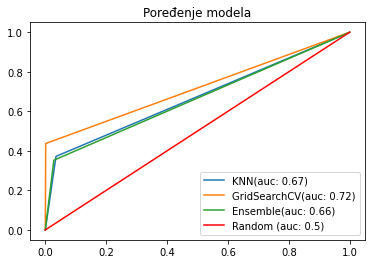

In [22]:
models = [knn, estimator.best_estimator_,baggingKnn]
model_names = ['KNN', 'GridSearchCV','Ensemble']
for model, model_name in zip(models, model_names):
    y_pred = model.predict(X_test)
    fpr,tpr, _ = roc_curve(Y_test, y_pred)
    auc = roc_auc_score(Y_test, y_pred)
    lab = model_name + "(auc: " + str(round(auc, 2)) + ")"
    plt.plot(fpr, tpr, label=lab)

plt.plot([0, 1], [0, 1], label='Random (auc: 0.5)', color='red')
plt.title("Poređenje modela")
plt.legend()
plt.show()
